<font size=6>
    Sberbank Russian Housing Market
</font>

<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>
<font color='red' size=5>
    Ongoing
</font>
<hr style="border: solid rgb(255,0,0) 0.0px; background-color: rgb(255,0,0);height: 2.0px;"/>

### Summary
1. Initial data exploration:
    * (rows, cols) = (30471, 292)
        * 275 cols are numeric

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import StandardScaler RobustScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

BASE_PATH = "../../datasets/sberbank-russian-housing-market/"

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(BASE_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../../datasets/sberbank-russian-housing-market/sample_submission.csv
../../datasets/sberbank-russian-housing-market/macro.csv
../../datasets/sberbank-russian-housing-market/test.csv
../../datasets/sberbank-russian-housing-market/data_dictionary.txt
../../datasets/sberbank-russian-housing-market/train.csv
../../datasets/sberbank-russian-housing-market/sberbank-russian-housing-market.zip
../../datasets/sberbank-russian-housing-market/__MACOSX/._test.csv
../../datasets/sberbank-russian-housing-market/__MACOSX/._train.csv


In [202]:
1

1

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 20)]
random.shuffle(colors)

## Load the data

In [3]:
df = pd.read_csv(BASE_PATH + 'train.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp'])

In [5]:
df.shape

(30471, 292)

In [135]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Data columns (total 292 columns):
id                                       30471 non-null int64
timestamp                                30471 non-null datetime64[ns]
full_sq                                  30471 non-null int64
life_sq                                  24088 non-null float64
floor                                    30304 non-null float64
max_floor                                20899 non-null float64
material                                 20899 non-null float64
build_year                               16866 non-null float64
num_room                                 20899 non-null float64
kitch_sq                                 20899 non-null float64
state                                    16912 non-null float64
product_type                             30471 non-null object
sub_area                                 30471 non-null object
area_m                                   30471 non-null f

In [26]:
df.head(10)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452
5,6,2011-09-06,67,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,62,14,1,53,78,1,20,113,17,9100000
6,7,2011-09-08,25,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,81,16,3,38,80,1,27,127,8,5500000
7,8,2011-09-09,44,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,11,18,1,0,47,4,2000000
8,9,2011-09-10,42,27.0,5.0,NaN,NaN,NaN,NaN,NaN,...,19,8,1,18,34,1,3,85,11,5300000
9,10,2011-09-13,36,21.0,9.0,NaN,NaN,NaN,NaN,NaN,...,19,13,0,10,20,1,3,67,1,2000000


In [4]:
X = df.select_dtypes("number").drop("price_doc", axis=1)

In [167]:
X.shape

(30471, 107)

In [6]:
y = df.price_doc
y.shape

(30471,)

In [172]:
df_test = pd.read_csv(BASE_PATH + 'test.csv', \
                 infer_datetime_format=True, parse_dates=['timestamp']).shape

<hr style="border: solid rgb(0,0,0) 0.0px; background-color: rgb(0,0,0);height: 5.0px;"/>

# Pipeline exploration

PLaying with sklearn's `pipeline` module.

In [15]:
# These didn't work, or had extreme R2-values
'''                                                                                                                                                                                                                                                                                                                                                                                                                                                              ElasticNet(),
    Lasso(),
    SGDRegressor(),
    SVR(),
    KernelRidge(),
    RandomForestRegressor(),    
'''
classif_list = \
[
    LinearRegression(),
    Ridge(),
    LinearSVR(),
    GradientBoostingRegressor()
]
for elem in classif_list:
    try:
        pipe = make_pipeline(SimpleImputer(), elem)        
        %time cv_mean = cross_val_score(pipe, X, y).mean()
        print(f"For {elem}\n\t\t the R2 score is: {cv_mean:.4f}\n")
    except:
        print(f"{elem} failed\n")

CPU times: user 11.7 s, sys: 4.76 s, total: 16.5 s
Wall time: 6.42 s
For LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
		 the R2 score is: -52.7664

CPU times: user 3.3 s, sys: 1.3 s, total: 4.6 s
Wall time: 2.17 s
For Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
		 the R2 score is: -50.7467

CPU times: user 2min 39s, sys: 896 ms, total: 2min 40s
Wall time: 2min 40s
For LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
		 the R2 score is: -22.9566

CPU times: user 8min 45s, sys: 475 ms, total: 8min 46s
Wall time: 8min 49s
For GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_

```
classif_list = \
[
    LinearRegression(),
    ElasticNet(),
    Lasso(),
    Ridge(),
    SGDRegressor(),
    SVR(),
    LinearSVR(),
    KernelRidge(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]
for elem in classif_list:
    try:
        pipe = make_pipeline(SimpleImputer(), elem)
        print(f"For {elem}\n\t\t the R2 score is: {cross_val_score(pipe, X, y).mean():.4f}")
    except:
        print(f"{elem} failed")
        
        
The R2 for LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False) score is: -52.7664
ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False) failed
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) failed
The R2 for Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001) score is: -50.7467
The R2 for SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False) score is: -814474132794275548079241717350400.0000
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) failed
The R2 for LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0) score is: -19.6381
KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None) failed
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) failed
The R2 for GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) score is: 0.6301
```

```
CPU times: user 11.7 s, sys: 4.76 s, total: 16.5 s
Wall time: 6.42 s
For LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
		 the R2 score is: -52.7664

CPU times: user 3.3 s, sys: 1.3 s, total: 4.6 s
Wall time: 2.17 s
For Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
		 the R2 score is: -50.7467

CPU times: user 2min 39s, sys: 896 ms, total: 2min 40s
Wall time: 2min 40s
For LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)
		 the R2 score is: -22.9566

CPU times: user 8min 45s, sys: 475 ms, total: 8min 46s
Wall time: 8min 49s
For GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
		 the R2 score is: 0.6288

```

## Feature importance study with XGBoost

In [16]:
classifiers = [
               xgb.XGBRegressor(objective="reg:squarederror"),
]

clf_names = [
            "xgboost    ",
];
#X = dtrain[dtrain.GrLivArea < 4000].drop(["SalePrice"], axis=1).copy()
#y = np.log1p(dtrain[dtrain.GrLivArea < 4000].SalePrice)
'''
# again we apply the boxcox transformation
sk = pd.DataFrame(X.iloc[:, :60].skew(), columns=["skewness"])
sk = sk[sk.skewness > .75]
for feature_ in sk.index:
    X[feature_] = boxcox1p(X[feature_], 0.15)

'''
n=0
pdf_co = pd.DataFrame()
for clf_name, clf in zip(clf_names, classifiers):
    coeffs = clf.fit(X, y).feature_importances_
    df_co = pd.DataFrame(coeffs, columns=["importance_"+clf_name.strip()])
    df_co.index = X.columns
    #print(df_co.shape)
    pdf_co = pd.concat([pdf_co, df_co], axis=1)
    #print(df_co.shape, pdf_co.shape)    
    n+=1



In [170]:
elem = xgb.XGBRegressor(objective="reg:squarederror")
pipe = make_pipeline(SimpleImputer(), elem)        
%time cv_mean = cross_val_score(pipe, X, y).mean()
print(f"For {elem}\n\t\t the R2 score is: {cv_mean:.4f}\n")

CPU times: user 2min 6s, sys: 132 ms, total: 2min 6s
Wall time: 35.7 s
For XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)
		 the R2 score is: 0.9988



In [35]:
pdf_co = pdf_co.sort_values('importance_xgboost', ascending=False).reset_index().rename(columns={'index':'feature'})
feat_max = pdf_co.importance_xgboost.max()
pdf_co['rescaled'] = pdf_co.importance_xgboost.apply(lambda x: x/feat_max)

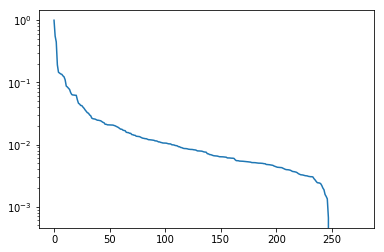

In [27]:
plt.plot(pdf_co.rescaled.values)
plt.yscale('log')

In [41]:
top100_xgbfeatures = pdf_co[pdf_co['rescaled']>0.01]['feature'].tolist()

In [136]:
all_cols = df.columns.tolist()

X = df.filter(all_cols, axis=1)
corr0 = X.select_dtypes(include="number").corr()

<font color=red size=3>
The version of X below,
</font>

`X = df.filter(top100_xgbfeatures+['price_doc'], axis=1)`
<br/><font color=red size=3>
seems to have exceptionally high R2 (0.9988) when using
</font>

`xgb.XGBRegressor(objective="reg:squarederror")`

In [137]:
# we drop Id (not relevant)
X = df.filter(top100_xgbfeatures+['price_doc'], axis=1)
corr = X.select_dtypes(include="number").corr()

In [154]:
corr_matched = corr0["price_doc"].sort_values(ascending=True)[:-1]\
                 .reset_index()\
                 .rename(columns={'index':'col_name'})\
                 .merge(corr["price_doc"].sort_values(ascending=True)[:-1]\
                 .reset_index()\
                 .rename(columns={'index':'col_name'}), on='col_name', how='outer', suffixes=['','_imp'])\
                 .fillna(value=0)

In [155]:
corr_matched['match'] = corr_matched.apply(lambda x: int(x['price_doc']==x['price_doc_imp']), axis=1)

In [156]:
corr_matched.head()

,col_name,price_doc,price_doc_imp,match
0,zd_vokzaly_avto_km,-0.284069,-0.284069,1
1,sadovoe_km,-0.283622,-0.283622,1
2,kremlin_km,-0.279249,0.000000,0
3,bulvar_ring_km,-0.279158,0.000000,0
4,ttk_km,-0.272620,-0.272620,1


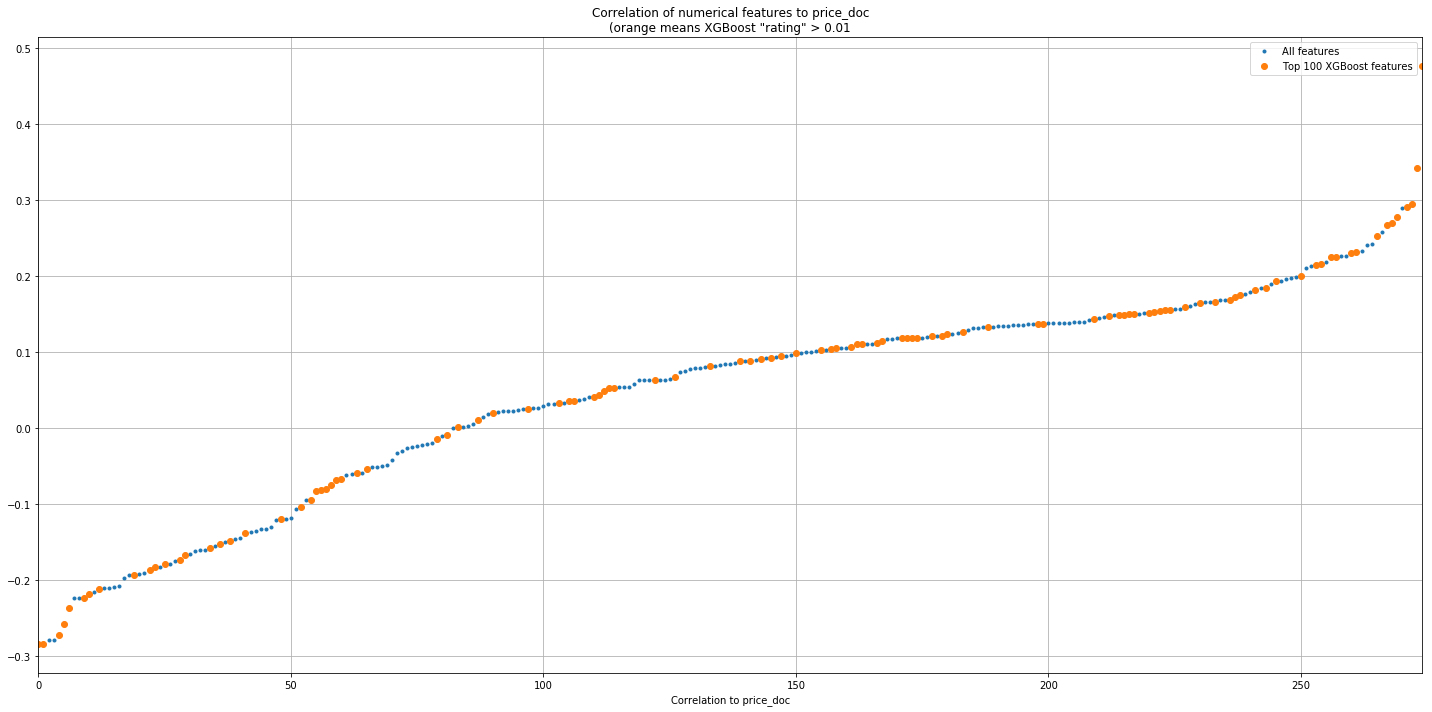

In [165]:
fig, ax = plt.subplots(1,1,figsize=(20,10));
"""
corr_matched.plot(x='col_name', y='price_doc', kind="bar", 
                  color=tuple(np.where(corr_matched['match']==1, 'C1', 'C0').tolist()), ax=ax)
"""
corr_matched.plot(y='price_doc', kind="line", linestyle='', marker='.', color='C0', ax=ax)

corr_matched[corr_matched['price_doc_imp']!=0].plot(y='price_doc_imp', kind="line", linestyle='', marker='o', color='C1', ax=ax)

plt.title("Correlation of numerical features to price_doc\n(orange means XGBoost \"rating\" > 0.01")
plt.xlabel("Correlation to price_doc")
plt.tight_layout()
plt.legend(['All features', 'Top 100 XGBoost features'])
plt.grid()
plt.show()

#### Heatmap of correlations

Many of the XGBoost-important features are correlated with each other

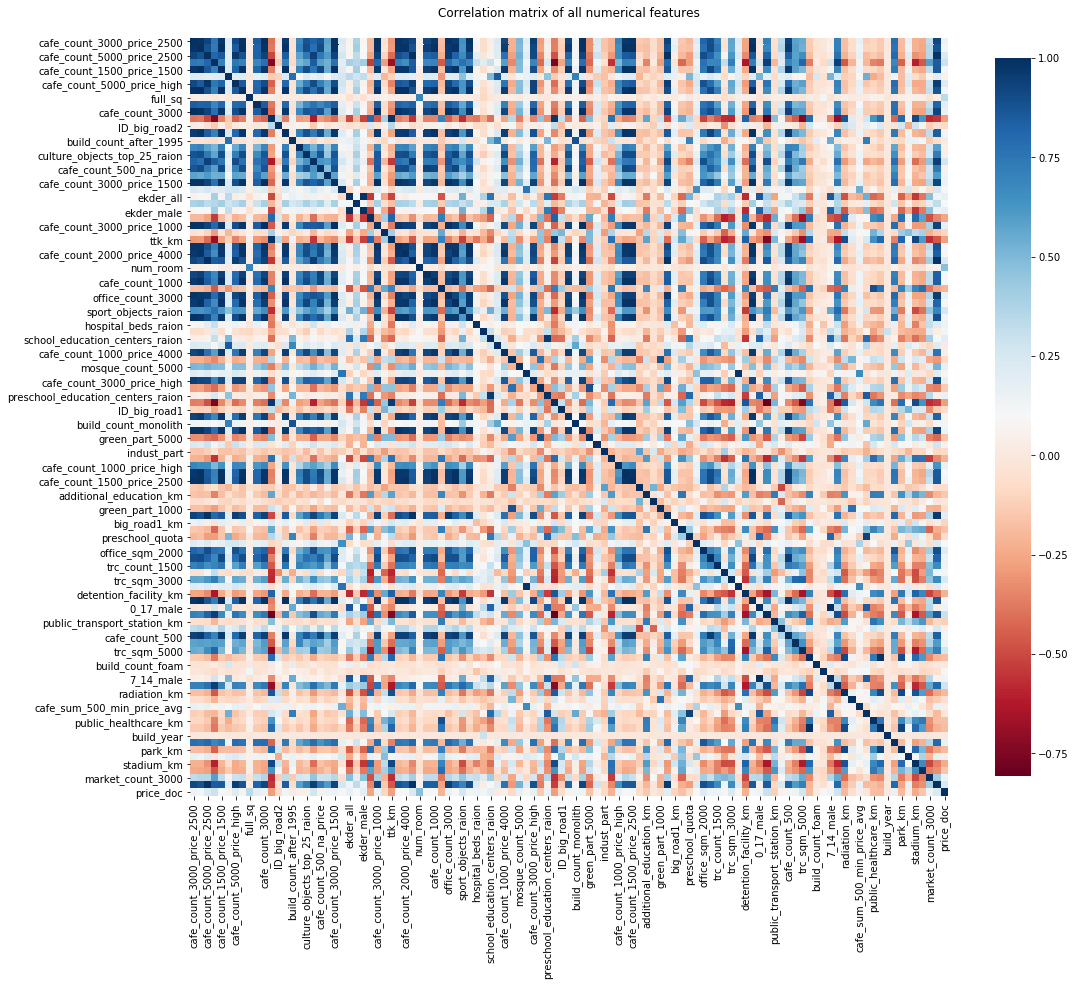

In [45]:
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

### Characterize the missing values

In [95]:
missing = [(c, df[c].isna().mean()*100) for c in df]
missing = pd.DataFrame(missing, columns=["column_name", "percent_missing"])
missing = missing[missing.percent_missing > 0]
display(missing.sort_values("percent_missing", ascending=False))

,column_name,percent_missing
24,hospital_beds_raion,47.392603
7,build_year,44.649011
10,state,44.498047
161,cafe_sum_500_max_price_avg,43.585704
160,cafe_sum_500_min_price_avg,43.585704
162,cafe_avg_price_500,43.585704
5,max_floor,31.413475
6,material,31.413475
8,num_room,31.413475
9,kitch_sq,31.413475


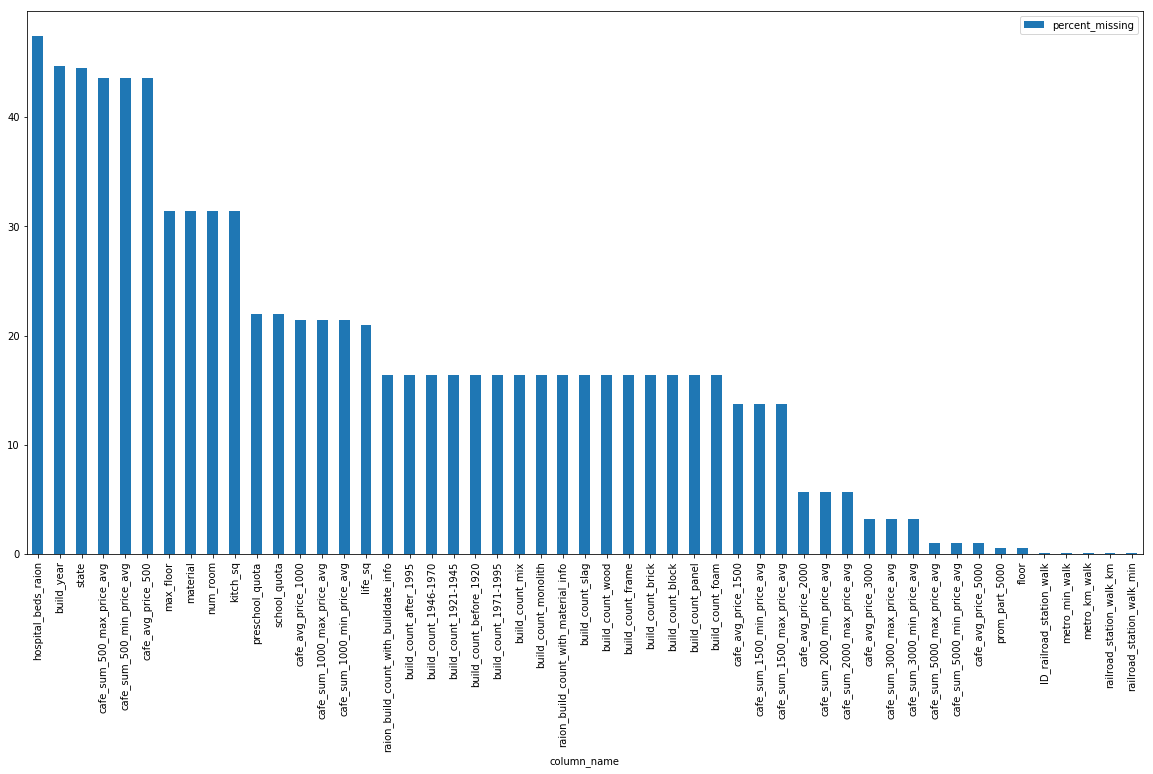

In [96]:
fig, ax = plt.subplots(1,1,figsize=[20,10])
missing.sort_values("percent_missing", ascending=False).plot.bar(x='column_name',y='percent_missing', ax=ax)

In [97]:
df.shape, missing.shape

((30471, 292), (51, 2))

In [98]:
missing_col_names = missing.column_name.values.tolist() + ['price_doc']
all_cols = df.columns.tolist()

In [99]:
all_full_cols = [item for item in all_cols if item not in missing_col_names]

In [100]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

X = df.filter(all_full_cols, axis=1).select_dtypes(include=numerics)

In [101]:
X.shape

(30471, 224)

In [102]:
full_top100_xgbfeatures = [item for item in top100_xgbfeatures if item not in missing_col_names]

In [106]:
len(full_top100_xgbfeatures)

86

<hr style="border: 4px dotted #aaaaaa; border-style: none none dotted; color: #fff; background-color: #fff;"/>

### Correlations

In [19]:
# we drop Id (not relevant)
X = df.filter(all_full_cols+['price_doc'], axis=1).select_dtypes(include=numerics)
corr = X.drop(["id"], axis=1).select_dtypes(include="number").corr()

In [20]:
corr.shape

(224, 224)

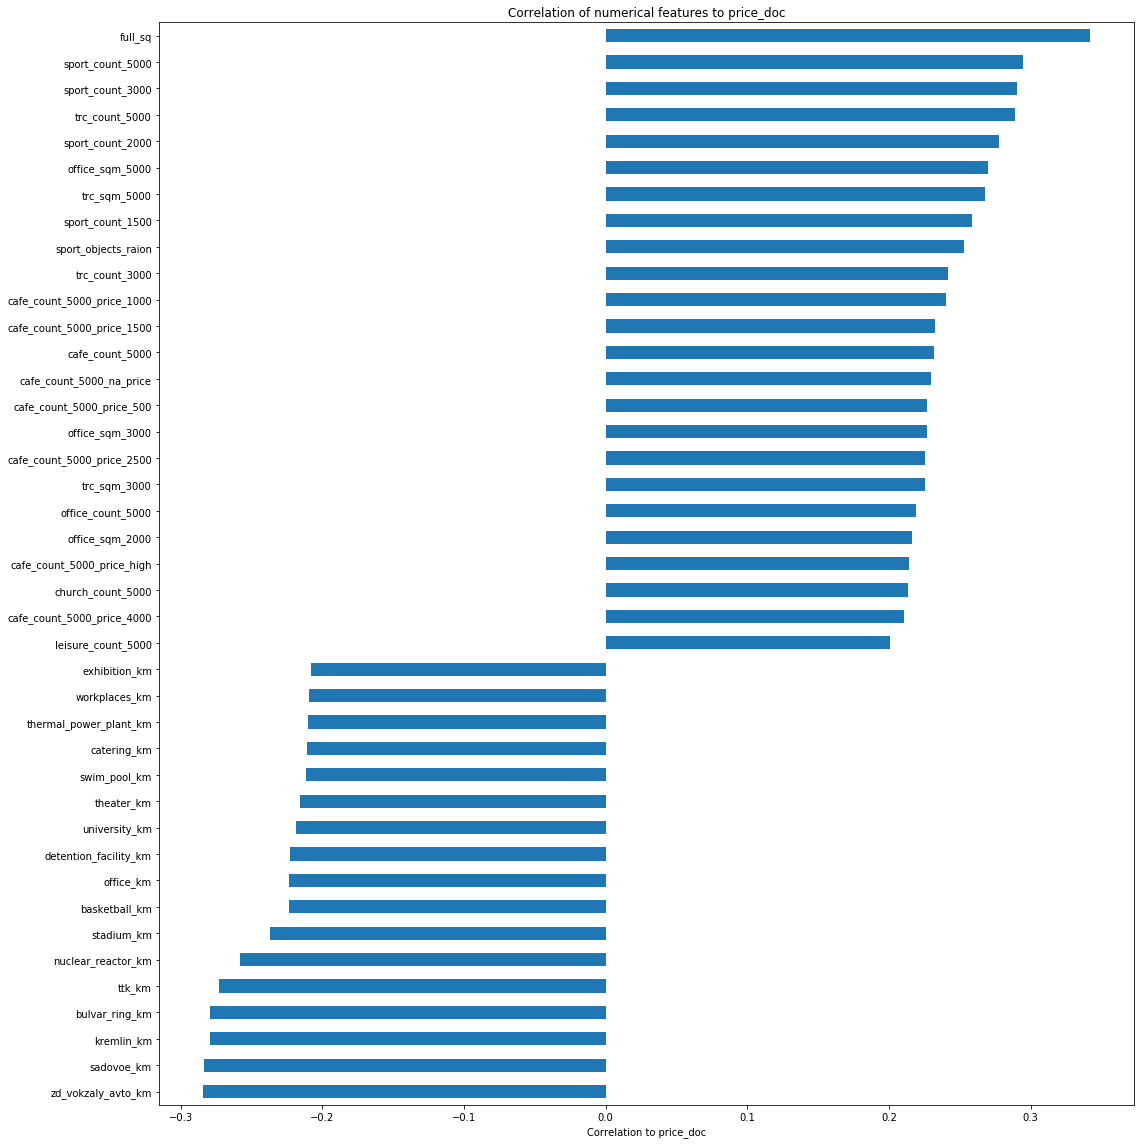

In [177]:
plt.figure(figsize=(16,16));
'''corr["price_doc"].sort_values(ascending=True)[:-1]\
                 .reset_index() \
                 .plot(y='index', kind="barh")'''
corr[abs(corr["price_doc"])>=0.2]["price_doc"].sort_values(ascending=True)[:-1]\
                 .plot(kind="barh")
plt.title("Correlation of numerical features to price_doc")
plt.xlabel("Correlation to price_doc")
plt.tight_layout()
plt.show()

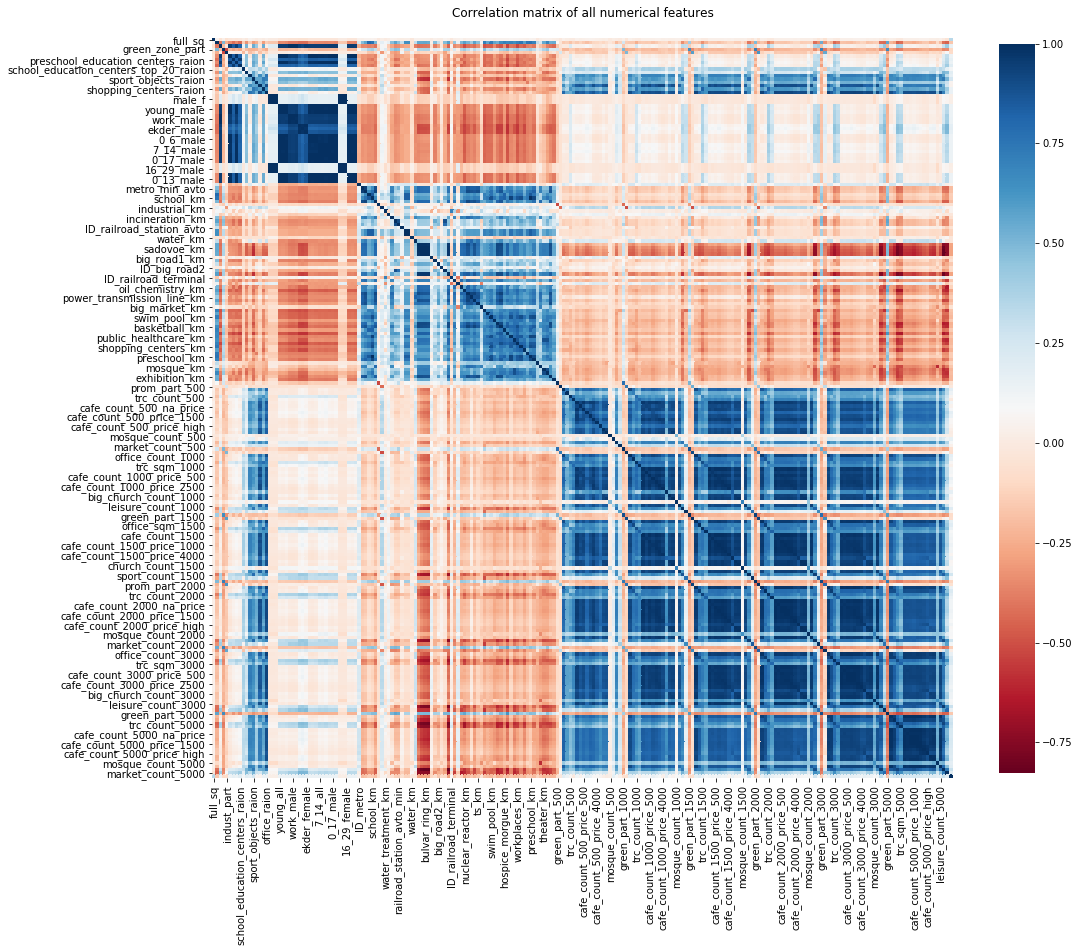

In [21]:
#sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

In [107]:
'price_doc' in full_top100_xgbfeatures

False

In [109]:
# we drop Id (not relevant)
X = df.filter(full_top100_xgbfeatures+['price_doc'], axis=1).select_dtypes(include=numerics)
corr = X.select_dtypes(include="number").corr()

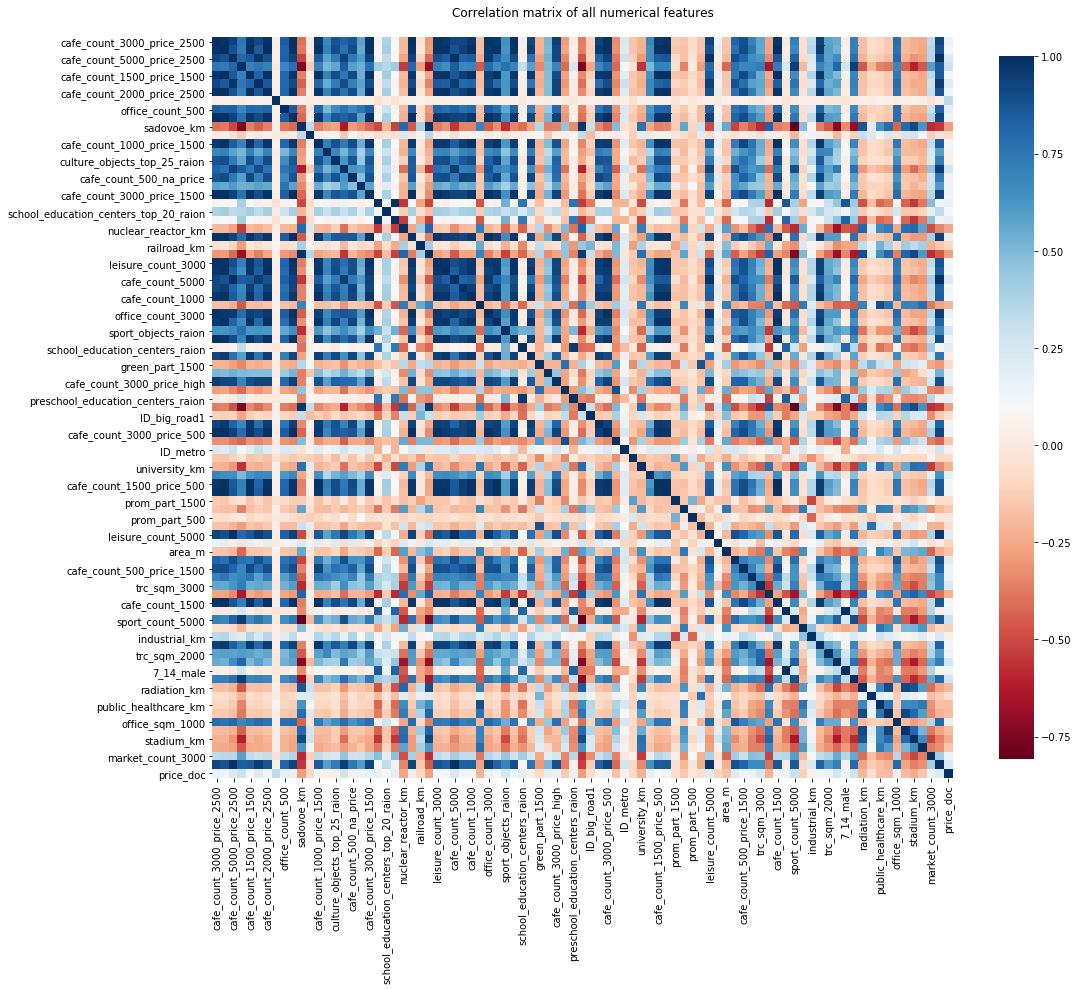

In [111]:
#sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(corr, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

### Reduce features: 

In [113]:
df_corr_sub = corr["price_doc"].reset_index()

In [118]:
high_corr_list = df_corr_sub[abs(df_corr_sub['price_doc'])>0.2]['index'].tolist()
high_corr_list = [item for item in high_corr_list if 'cafe' not in item]
high_corr_list += ['cafe_count_5000_price_1000']

In [119]:
df_corr2 = df.filter(high_corr_list, axis=1).select_dtypes(include=numerics)
df_corr2 = df_corr2.select_dtypes(include="number").corr()

In [120]:
df.filter(high_corr_list, axis=1).head()

,sport_count_3000,full_sq,sadovoe_km,office_sqm_5000,nuclear_reactor_km,ttk_km,swim_pool_km,sport_objects_raion,zd_vokzaly_avto_km,university_km,leisure_count_5000,office_sqm_2000,trc_sqm_3000,detention_facility_km,sport_count_5000,trc_sqm_5000,sport_count_2000,stadium_km,price_doc,cafe_count_5000_price_1000
0,21,43,13.100618,807385,5.718519,10.918587,3.065047,7,14.231961,6.715026,0,188854,1419204,4.248036,52,4036616,10,8.148591,5850000,48
1,19,34,6.444333,2690465,3.489954,3.103996,2.000154,6,9.242586,1.852560,10,165510,491565,12.649879,66,2034942,11,6.127073,6000000,65
2,20,43,6.963403,1478160,7.506612,2.927487,1.239304,5,9.540544,0.841254,4,100200,52550,7.682303,67,1572990,8,0.767569,5700000,45
3,18,89,17.457198,244166,9.522538,14.606501,1.950317,17,17.478380,10.903161,0,11000,205756,8.789894,26,942180,13,7.385521,13100000,21
4,77,77,0.046810,8404624,8.671016,1.721834,2.544696,25,1.595898,0.991683,91,1625130,2296870,3.779781,195,3503058,21,3.610754,16331452,578


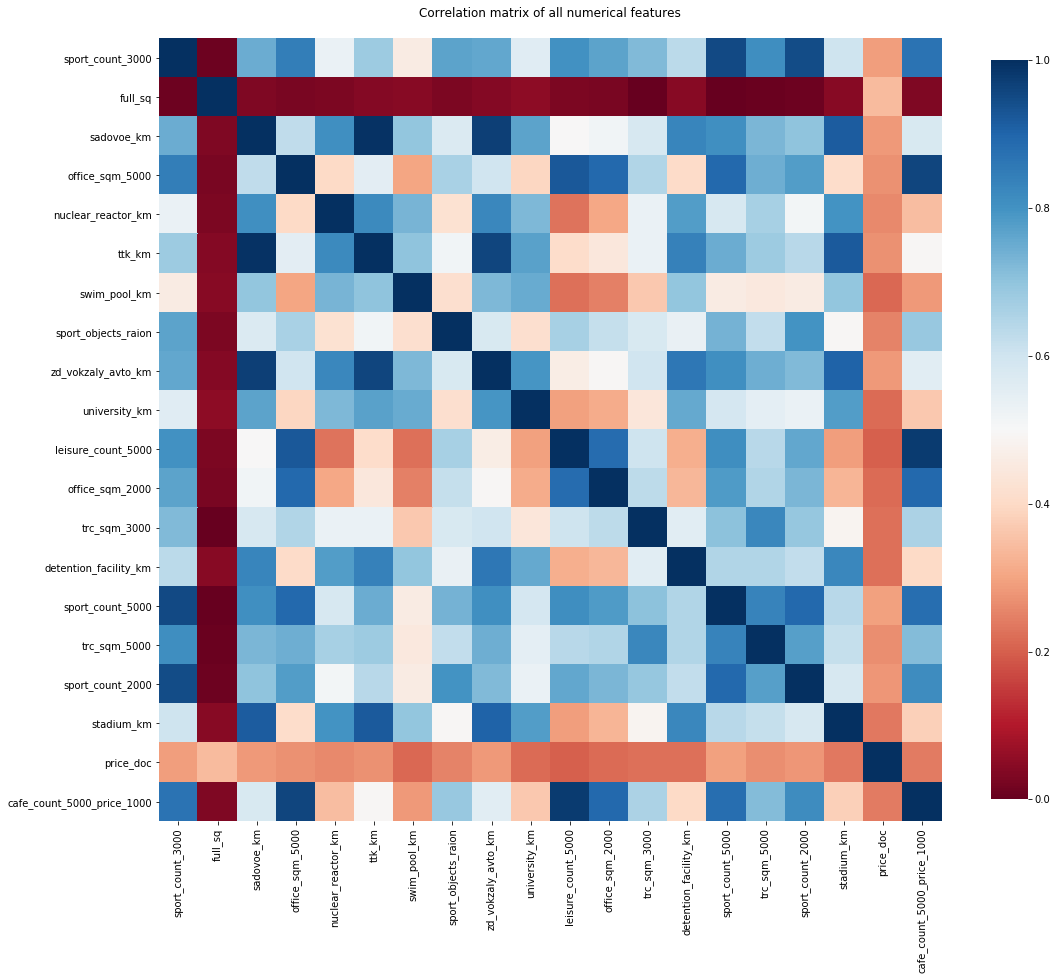

In [131]:
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(abs(df_corr2), cmap="RdBu", vmin=0, vmax=1, square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

In [126]:
df_corr3 = df.filter([item for item in high_corr_list if 'cafe' in item]+['price_doc'], axis=1)
df_corr3 = df_corr3.select_dtypes(include="number").corr()

In [67]:
cols_with_count = [item for item in high_corr_list if 'count' in item]
len(cols_with_count)
print(cols_with_count)

['sport_count_1500', 'sport_count_2000', 'trc_count_3000', 'sport_count_3000', 'office_count_5000', 'trc_count_5000', 'church_count_5000', 'leisure_count_5000', 'sport_count_5000', 'cafe_count_5000_price_1000']


In [73]:
sport_cols = [item for item in all_full_cols if ('sport' in item) & ('transport' not in item)]
trc_cols = [item for item in all_full_cols if 'trc' in item]

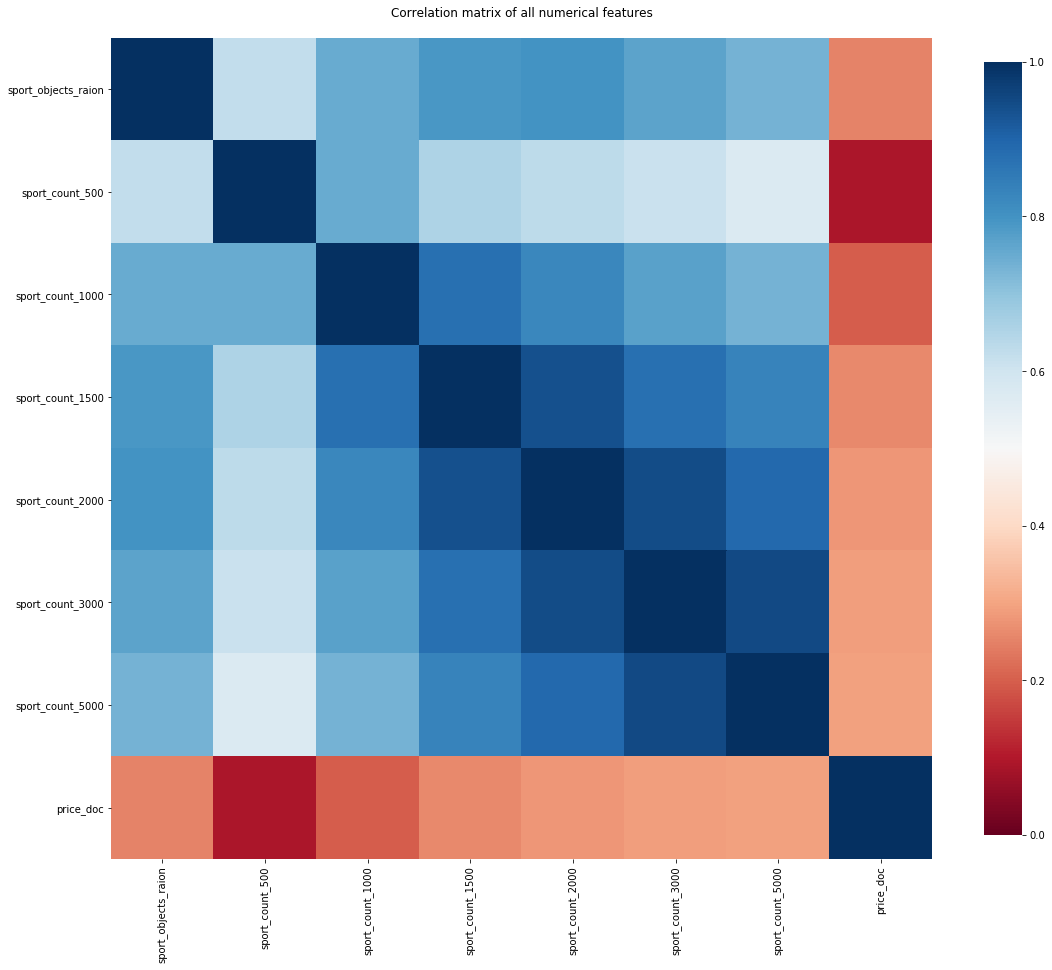

In [76]:
df_corr3 = df.filter(sport_cols+['price_doc'], axis=1).select_dtypes(include=numerics)
df_corr3 = df_corr3.select_dtypes(include="number").corr()
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(df_corr3, cmap="RdBu", vmin=0, vmax=1, square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

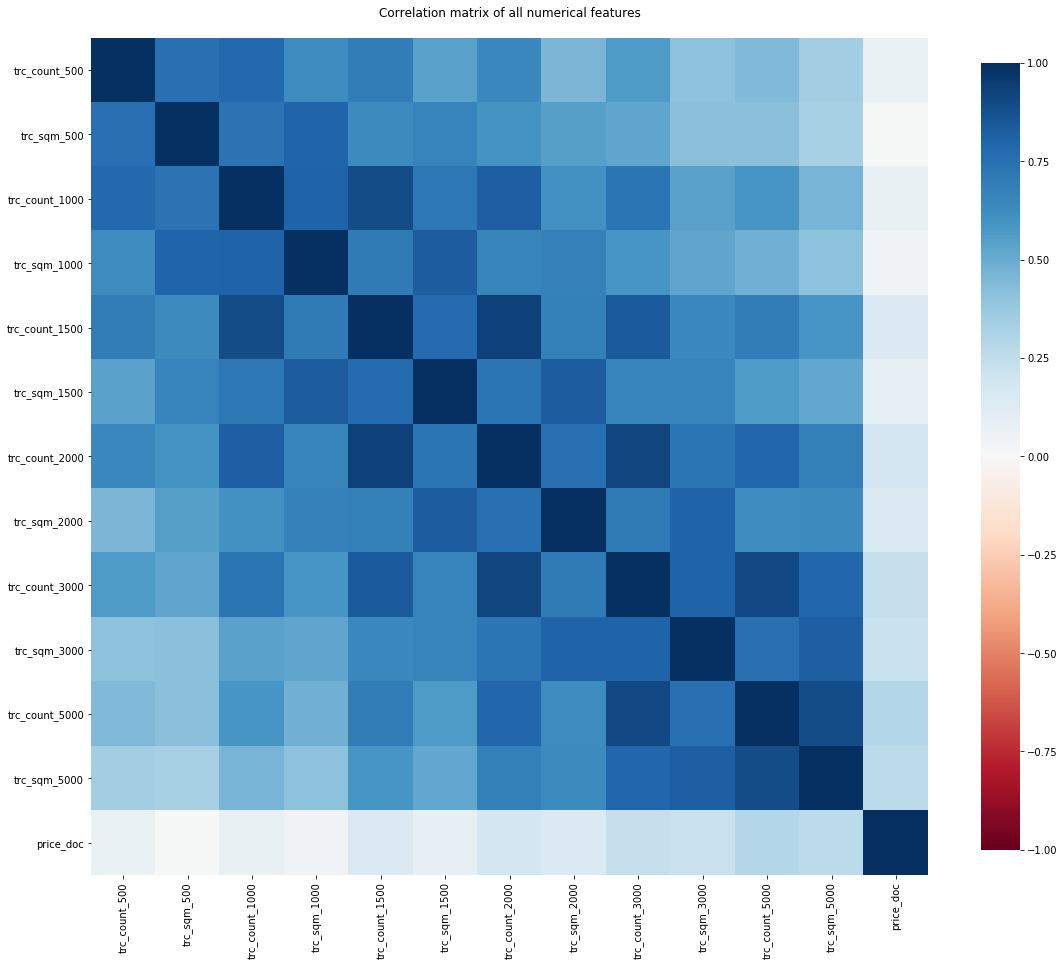

In [78]:
df_corr3 = df.filter(trc_cols+['price_doc'], axis=1).select_dtypes(include=numerics)
df_corr3 = df_corr3.select_dtypes(include="number").corr()
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(df_corr3, cmap="RdBu", vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

In [ ]:
df_corr2 = df.filter(high_corr_list, axis=1).select_dtypes(include=numerics)
df_corr2 = df_corr2.select_dtypes(include="number").corr()

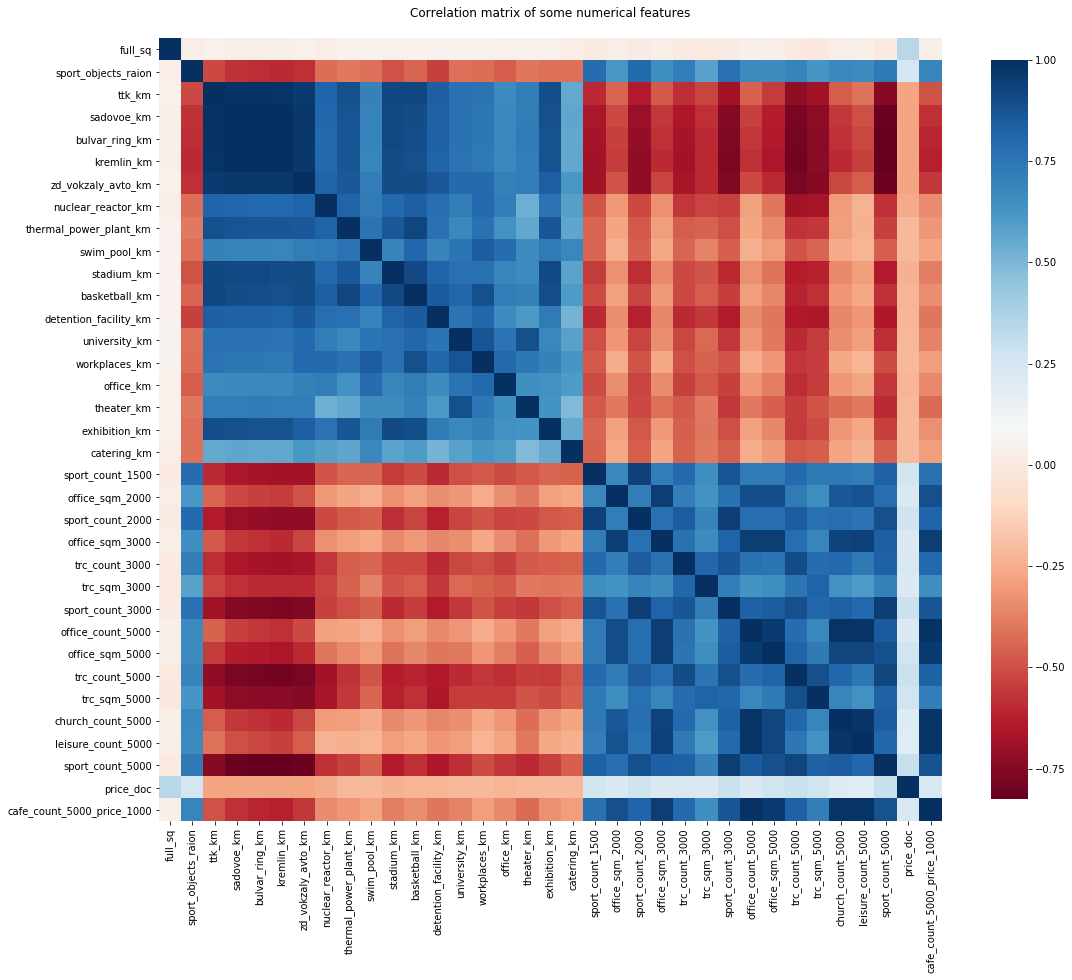

In [207]:
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(16,16));
sns.heatmap(df_corr2, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of some numerical features\n")
plt.tight_layout()
plt.show()

In [85]:
df_corr2_stack = df_corr2.stack().reset_index()
df_corr2_stack.columns = ['col1', 'col2', 'corr_coef']
df_corr2_stack = df_corr2_stack[df_corr2_stack['col1']!=df_corr2_stack['col2']].copy()

In [86]:
df_corr2_stack.head()

,col1,col2,corr_coef
1,full_sq,sport_objects_raion,0.028109
2,full_sq,ttk_km,0.040186
3,full_sq,sadovoe_km,0.034145
4,full_sq,bulvar_ring_km,0.033279
5,full_sq,kremlin_km,0.031128


In [102]:
#intern_high_corr_cols  = 
df_intercorr = df_corr2_stack[df_corr2_stack['corr_coef']>=0.9]\
    .sort_values('corr_coef',ascending=False)\
    .reset_index(drop=True) \
    .drop_duplicates(subset='corr_coef')
df_intercorr.head()

,col1,col2,corr_coef
0,bulvar_ring_km,kremlin_km,0.998804
2,sadovoe_km,bulvar_ring_km,0.998443
4,kremlin_km,sadovoe_km,0.997456
6,ttk_km,sadovoe_km,0.992477
8,cafe_count_5000_price_1000,office_count_5000,0.990976


In [104]:
from collections import Counter

In [106]:
col1_counted = Counter(df_intercorr.col1.tolist())
col2_counted = Counter(df_intercorr.col2.tolist())

In [133]:
pdf_col1_counted = pd.DataFrame.from_dict(col1_counted, orient='index')\
    .reset_index()\
    .rename(columns={'index':'col', 0:'count'})
pdf_col2_counted = pd.DataFrame.from_dict(col2_counted, orient='index')\
    .reset_index()\
    .rename(columns={'index':'col', 0:'count'})
pdf_col_counted = pdf_col1_counted\
    .merge(pdf_col2_counted, 
           on='col', how='outer', 
           suffixes=['_1','_2'])

In [138]:
pdf_col1_counted.head()

,col,count
0,bulvar_ring_km,1
1,sadovoe_km,2
2,kremlin_km,1
3,ttk_km,3
4,cafe_count_5000_price_1000,3


In [139]:
pdf_col2_counted.head()

,col,count
0,kremlin_km,4
1,bulvar_ring_km,4
2,sadovoe_km,4
3,office_count_5000,2
4,church_count_5000,3


In [134]:
pdf_col_counted

,col,count_1,count_2
0,bulvar_ring_km,1.0,4.0
1,sadovoe_km,2.0,4.0
2,kremlin_km,1.0,4.0
3,ttk_km,3.0,3.0
4,cafe_count_5000_price_1000,3.0,2.0
5,office_count_5000,3.0,2.0
6,leisure_count_5000,2.0,3.0
7,church_count_5000,2.0,3.0
8,zd_vokzaly_avto_km,4.0,2.0
9,office_sqm_5000,3.0,2.0


In [142]:
pdf_col_counted['max'] = pdf_col_counted\
    .fillna(0.0)\
    .apply(lambda x: max(x['count_1'],x['count_2']), axis=1)
pdf_col_counted['max_col'] = pdf_col_counted\
    .fillna(0.0)\
    .apply(lambda x: int(x['count_1']<=x['count_2'])+1, axis=1)
pdf_col_counted = pdf_col_counted\
    .sort_values('max', ascending=False)\
    .reset_index(drop=True)

In [143]:
pdf_col_counted

,col,count_1,count_2,max,max_col
0,stadium_km,6.0,1.0,6.0,1
1,kremlin_km,1.0,4.0,4.0,2
2,zd_vokzaly_avto_km,4.0,2.0,4.0,1
3,sadovoe_km,2.0,4.0,4.0,2
4,bulvar_ring_km,1.0,4.0,4.0,2
5,church_count_5000,2.0,3.0,3.0,2
6,basketball_km,3.0,2.0,3.0,1
7,office_sqm_5000,3.0,2.0,3.0,1
8,office_sqm_3000,3.0,3.0,3.0,2
9,leisure_count_5000,2.0,3.0,3.0,2


In [173]:
print('test')

test


### Notes
Want to get those cols 
* which are highly correlated with each other
* get the one which has the most correlations with other columns
* save it
* and remove the other columns dependent upon it from the list

The result should be a thinned down column list.

In [202]:
col1_counted_keys = list(col1_counted.keys())
col2_counted_keys = list(col2_counted.keys())

cols_to_save = []

for n, row in pdf_col_counted.iterrows():
    
    key=row['col']
    
    print(key,col1_counted[key], len(col1_counted_keys), col2_counted[key], len(col2_counted_keys))
    
    if (key not in col1_counted_keys) | (key not in col2_counted_keys):
        print('\tskipping',key)
        continue

    cols_to_save.append(key)
    
    max_col = row['max_col']
    key_col=f'col{max_col}'
    target_col=f'col{(max_col%2)+1}'
    #print(max_col,key_col, target_col)
    
    rem_keys = df_intercorr[df_intercorr[key_col]==key][target_col].tolist()
    
    col1_counted_keys= [key_ for key_ in col1_counted_keys if key_ not in rem_keys]
    col2_counted_keys= [key_ for key_ in col2_counted_keys if key_ not in rem_keys]
        
    if (len(col1_counted_keys)==0) & (len(col2_counted_keys)==0):
        print('lists are empty!')
        break
print(len(cols_to_save),':',cols_to_save)   

cols_to_drop = [col for col in pdf_col_counted.col.tolist() if col not in cols_to_save]

stadium_km 6 18 1 19
kremlin_km 1 13 4 13
	skipping kremlin_km
zd_vokzaly_avto_km 4 13 2 13
	skipping zd_vokzaly_avto_km
sadovoe_km 2 13 4 13
	skipping sadovoe_km
bulvar_ring_km 1 13 4 13
	skipping bulvar_ring_km
church_count_5000 2 13 3 13
basketball_km 3 10 2 10
office_sqm_5000 3 9 2 9
office_sqm_3000 3 9 3 9
	skipping office_sqm_3000
leisure_count_5000 2 9 3 9
office_count_5000 3 8 2 8
	skipping office_count_5000
cafe_count_5000_price_1000 3 8 2 8
	skipping cafe_count_5000_price_1000
ttk_km 3 8 3 8
	skipping ttk_km
trc_count_5000 0 8 2 8
	skipping trc_count_5000
sport_count_5000 2 8 0 8
	skipping sport_count_5000
thermal_power_plant_km 1 8 0 8
	skipping thermal_power_plant_km
sport_count_2000 1 8 1 8
trc_count_3000 1 7 0 7
	skipping trc_count_3000
office_sqm_2000 0 7 1 7
	skipping office_sqm_2000
sport_count_1500 0 7 1 7
	skipping sport_count_1500
sport_count_3000 1 7 1 7
	skipping sport_count_3000
exhibition_km 0 7 1 7
	skipping exhibition_km
6 : ['stadium_km', 'church_count_5000',

In [203]:
cols_to_drop

['kremlin_km',
 'zd_vokzaly_avto_km',
 'sadovoe_km',
 'bulvar_ring_km',
 'office_sqm_3000',
 'office_count_5000',
 'cafe_count_5000_price_1000',
 'ttk_km',
 'trc_count_5000',
 'sport_count_5000',
 'thermal_power_plant_km',
 'trc_count_3000',
 'office_sqm_2000',
 'sport_count_1500',
 'sport_count_3000',
 'exhibition_km']

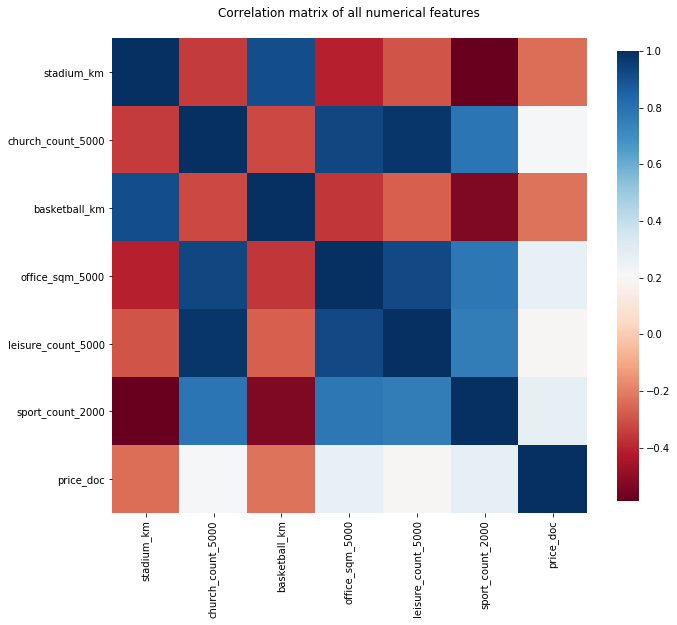

In [206]:
df_corr4 = df.filter(cols_to_save+['price_doc'], axis=1).select_dtypes(include=numerics)
df_corr4 = df_corr4.select_dtypes(include="number").corr()
# sort by SalePrice to make more sense in row order
plt.subplots(figsize=(10,10));
sns.heatmap(df_corr4, cmap="RdBu", square=True, cbar_kws={"shrink": .7})
plt.title("Correlation matrix of all numerical features\n")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import StandardScaler RobustScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [192]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import StandardScaler RobustScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

diabetes = datasets.load_diabetes()
rows=400
X = diabetes.data[:rows]
y = diabetes.target[:rows]
lasso = Lasso()

cvs = []
nr_of_splits = 150
nr_of_splits = range(2,nr_of_splits+2)
for n in nr_of_splits:
    cv =cross_val_score(lasso, X, y, cv=n)
    cvs.append(cv.mean())

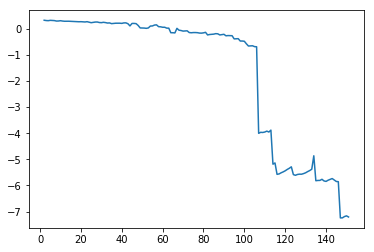

In [200]:
plt.plot(nr_of_splits,cvs)